In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from tbparse import SummaryReader

from pathlib import Path

In [2]:
DATA_DIR = Path("data")

df = SummaryReader(DATA_DIR, extra_columns = {'dir_name'}).scalars

In [3]:
print(df.head())
print(len(df["dir_name"].unique()))

   step         tag     value                        dir_name
0     0  Actor_Loss -0.005385  q2_pg_cartpole_lb_na_seed_2370
1     1  Actor_Loss -0.011389  q2_pg_cartpole_lb_na_seed_2370
2     2  Actor_Loss -0.009483  q2_pg_cartpole_lb_na_seed_2370
3     3  Actor_Loss -0.012173  q2_pg_cartpole_lb_na_seed_2370
4     4  Actor_Loss -0.008269  q2_pg_cartpole_lb_na_seed_2370
80


In [37]:
# Also segregate them by batch size.
df_small = df[~df['dir_name'].str.contains('lb')]
df_large = df[df['dir_name'].str.contains('lb')]

print(df_large.head())

   step         tag     value                        dir_name  smoothed_value
0     0  Actor_Loss -0.005385  q2_pg_cartpole_lb_na_seed_2370       -0.005385
1     1  Actor_Loss -0.011389  q2_pg_cartpole_lb_na_seed_2370       -0.005985
2     2  Actor_Loss -0.009483  q2_pg_cartpole_lb_na_seed_2370       -0.006335
3     3  Actor_Loss -0.012173  q2_pg_cartpole_lb_na_seed_2370       -0.006919
4     4  Actor_Loss -0.008269  q2_pg_cartpole_lb_na_seed_2370       -0.007054


/var/folders/8p/bg_0tch55qv9k4170yv61d4c0000gn/T/ipykernel_11843/3005880592.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['smoothed_value'] = df_small.groupby('tag')['value'].transform(
/var/folders/8p/bg_0tch55qv9k4170yv61d4c0000gn/T/ipykernel_11843/3005880592.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_large['smoothed_value'] = df_large.groupby('tag')['value'].transform(


,expt_type,smoothed_value_env_steps,smoothed_value_return
0,LB,4000,22.325294
1,LB,8000,28.415605
2,LB,12000,35.079499
3,LB,16000,42.990774
4,LB,20000,48.440314
5,LB,24000,55.057848
6,LB,28000,63.386209
7,LB,32000,69.072078
8,LB,36000,72.083820
9,LB,40000,83.968359


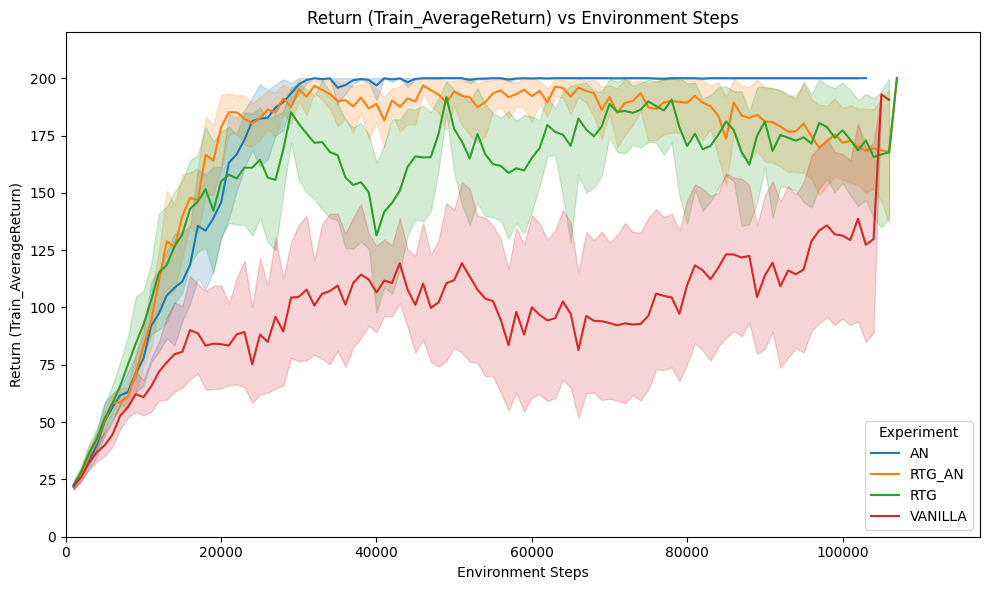

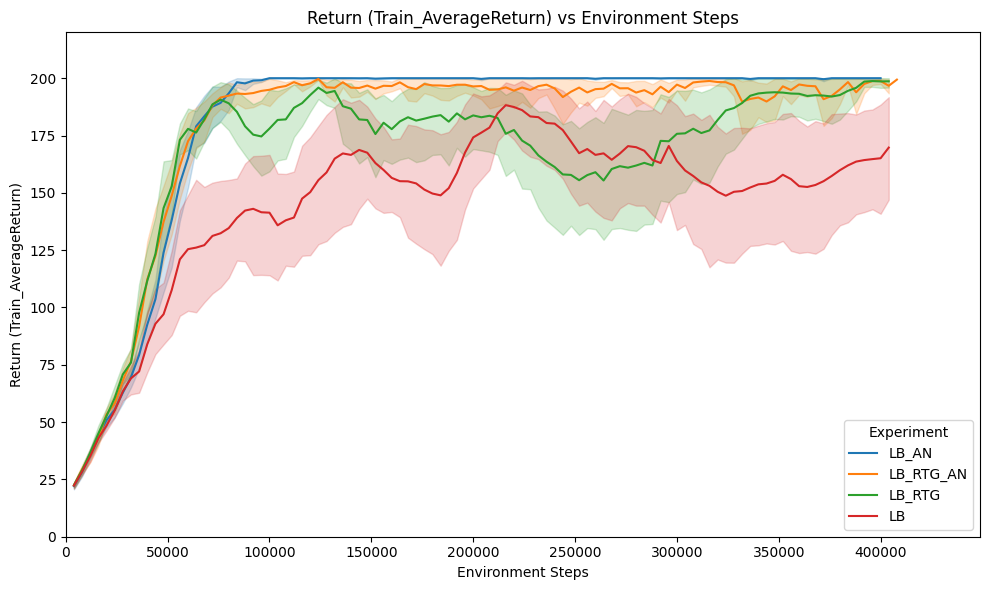

In [54]:
def plot_return_over_env_steps(df, return_key, env_steps_key, batch_size):
    # We want to plot average return over time.
    # => Left Join on 'step' and 'dir_name'
    return_df = df[df['tag'] == return_key][['step', 'value', 'dir_name']]
    env_steps_df = df[df['tag'] == env_steps_key][['step', 'value', 'dir_name']]
    joined_df = pd.merge(return_df, env_steps_df, on=['step', 'dir_name'], suffixes=('_return', '_env_steps'))
    joined_df['expt_type'] = joined_df['dir_name'].apply(
        lambda name: "_".join(name.split("_")[3:-2]).upper().replace("NA", "AN") if len(name.split("_")) > 5 else "VANILLA"
        # lambda name: "_".join(name.split("_")[3:-2]).upper() if len(name.split("_")) > 5 else "VANILLA"
    )
    joined_df['seed'] = joined_df['dir_name'].apply(
        lambda name: name.split("_")[-1] if len(name.split("_")) > 5 else "0"
    )
    # Suppress env steps to the nearest batch_size for plotting convenience.
    joined_df['value_env_steps'] = (joined_df['value_env_steps'] // batch_size) * batch_size
    joined_df['value_env_steps'] = joined_df['value_env_steps'].astype(int)

    # Smooth the return values so we can see trends better.
    # Note that we have multiple seeds per experiment type.
    joined_df['smoothed_value_return'] = joined_df['value_return']
    joined_df['smoothed_value_env_steps'] = joined_df['value_env_steps']
    # joined_df['smoothed_value_return'] = joined_df.groupby(['expt_type', 'seed'])['value_return'].transform(
    #     lambda x: x.ewm(span=10, adjust=False).mean()
    # )
    # joined_df['smoothed_value_env_steps'] = joined_df.groupby(['expt_type', 'seed'])['value_env_steps'].transform(
    #     lambda x: x.rolling(window=10, min_periods=1).mean()
    # )

    # Create standardized plot (x: [0, 200], y: env step range)
    fig, axs = plt.subplots(figsize=(10, 6))
    sns.lineplot(
        data=joined_df,
        x='smoothed_value_env_steps',
        y='smoothed_value_return',
        hue='expt_type',
        palette='tab10',
        legend='full',
        ax=axs
    )
    axs.set_title(f'Return ({return_key}) vs Environment Steps')
    axs.set_xlabel('Environment Steps')
    axs.set_ylabel(f'Return ({return_key})')
    axs.set_xlim(0, max(joined_df['smoothed_value_env_steps']) * 1.1)
    axs.set_ylim(0, 200 * 1.1)
    axs.legend(title='Experiment', loc='lower right')
    plt.tight_layout()
    return fig, joined_df


# Test: Check we merge properly for the most basic expt.

fig, joined_df = plot_return_over_env_steps(
    df_small,
    return_key='Train_AverageReturn',
    env_steps_key='Train_EnvstepsSoFar',
    batch_size=1000
)


fig, joined_df = plot_return_over_env_steps(
    df_large,
    return_key='Train_AverageReturn',
    env_steps_key='Train_EnvstepsSoFar',
    batch_size=4000
)

scores = joined_df.groupby(['expt_type', 'smoothed_value_env_steps'])['smoothed_value_return'].mean().reset_index()
scores = scores[scores['expt_type'] == 'LB']
scores.head(32)

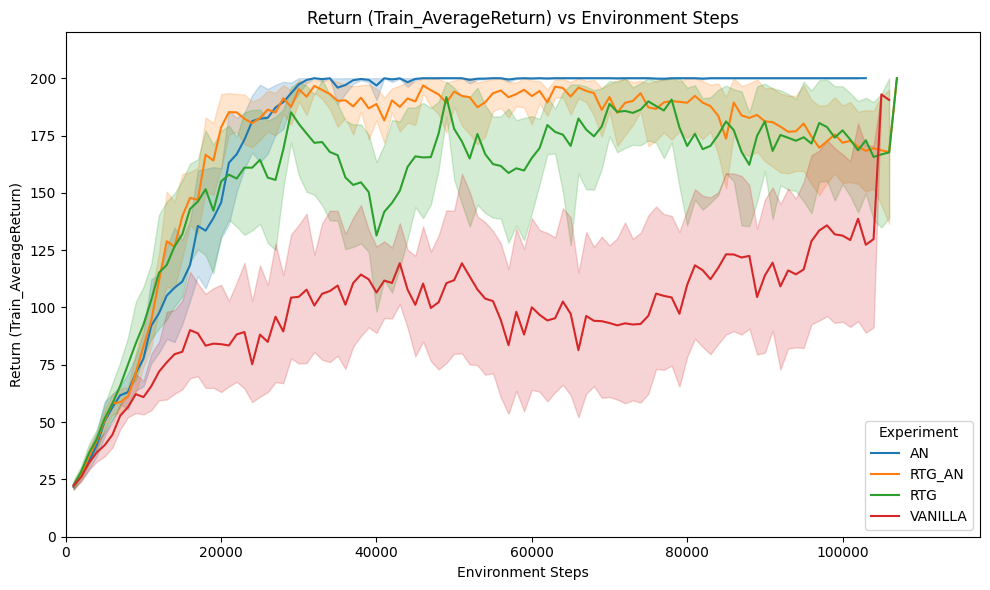

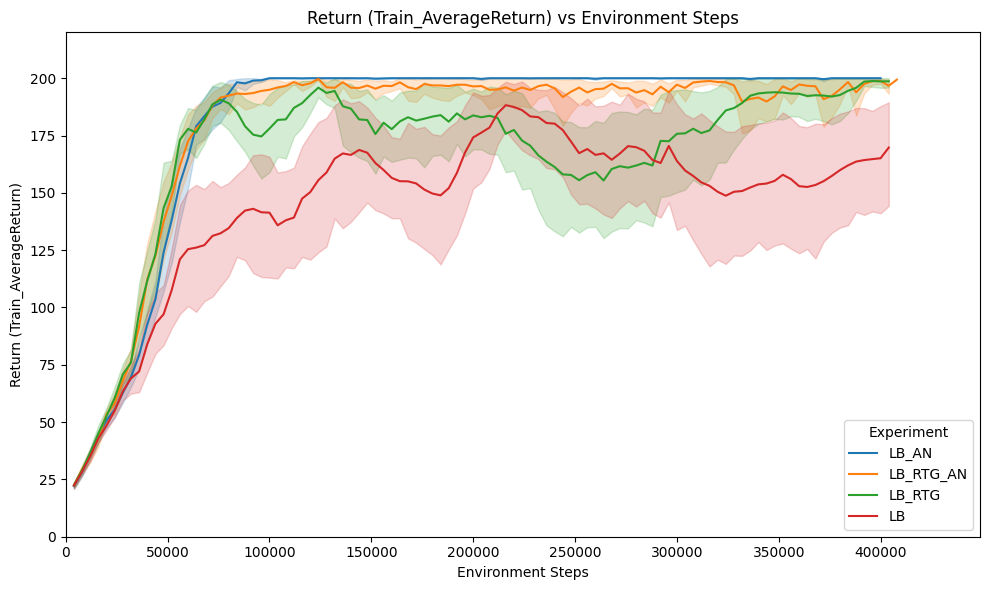

In [56]:
# Now plot for both small and large batch sizes.
fig_small, joined_df_small = plot_return_over_env_steps(
    df_small,
    return_key='Train_AverageReturn',
    env_steps_key='Train_EnvstepsSoFar',
    batch_size=1000
)
fig_large, joined_df_large = plot_return_over_env_steps(
    df_large,
    return_key='Train_AverageReturn',
    env_steps_key='Train_EnvstepsSoFar',
    batch_size=4000
)
Path('data', 'plots').mkdir(exist_ok=True, parents=True)
fig_small.savefig(Path('data', 'plots', 'return-vs-env-steps-small-batch.png'))
fig_large.savefig(Path('data', 'plots', 'return-vs-env-steps-large-batch.png'))

/var/folders/8p/bg_0tch55qv9k4170yv61d4c0000gn/T/ipykernel_11843/1522321456.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/var/folders/8p/bg_0tch55qv9k4170yv61d4c0000gn/T/ipykernel_11843/1522321456.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/var/folders/8p/bg_0tch55qv9k4170yv61d4c0000gn/T/ipykernel_11843/1522321456.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/var/folders/8p/bg_0tch55qv9k4170yv61d4c0000gn/T/ipykernel_11843/1522321456.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/var/folders/8p/bg_0tch55qv9k4170yv61d4c0000gn/T/ipykernel_11843/1522321456.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/var/folders/8p/bg_0tch55qv9k4170yv61d4c0000gn/T/ipykernel_11843/1522321456.py:21: UserWarning: Ignoring `palette` becau

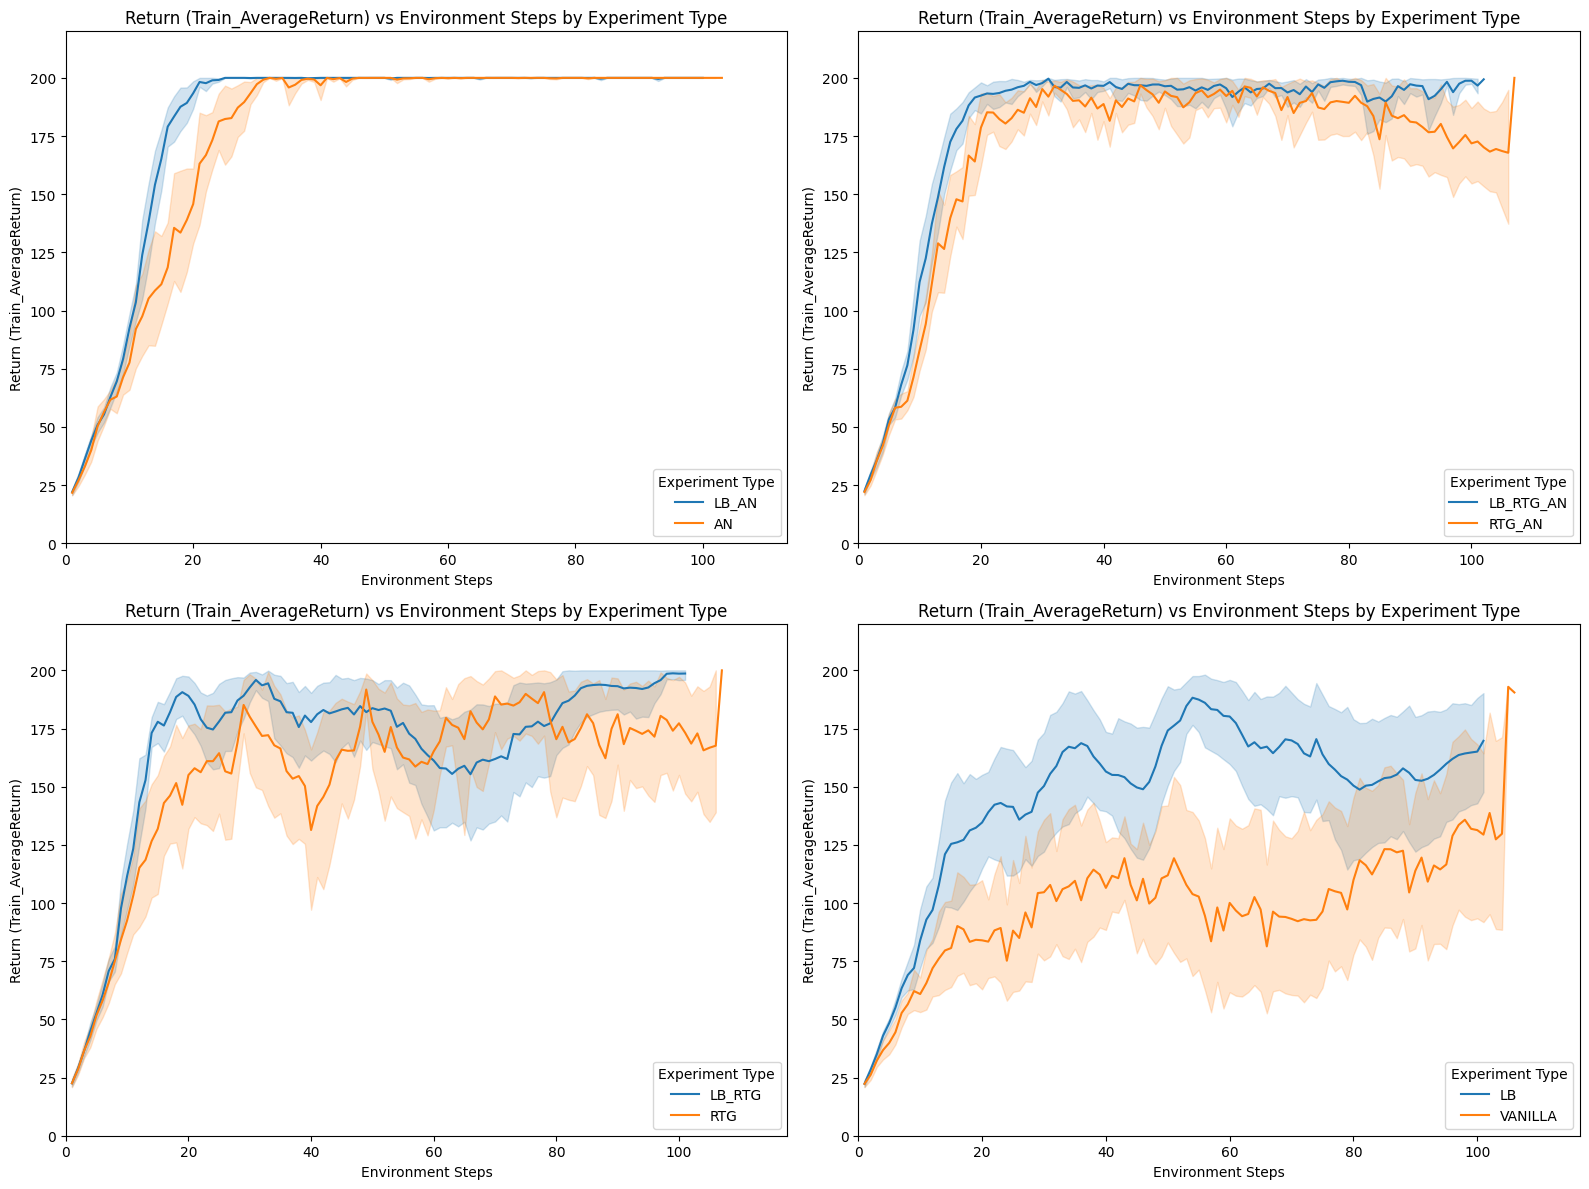

In [74]:
# Superpose the scores for large and small batch sizes.
df['expt_type'] = df['dir_name'].apply(
    lambda name: "_".join(name.split("_")[3:-2]).upper().replace("NA", "AN") if len(name.split("_")) > 5 else "VANILLA"
)
dfs_by_expt_type = {}
for expt_type in df['expt_type'].unique():
    dfs_by_expt_type[expt_type] = df[df['expt_type'] == expt_type]

# Plot the scores for each experiment type.
def plot_scores_by_experiment_type(dfs_by_expt_type, return_key, env_steps_key):
    fig, axs = plt.subplots(figsize=(16, 12), nrows=2, ncols=2)
    for i, (expt_type, df) in enumerate(dfs_by_expt_type.items()):
        return_df = df[df['tag'] == return_key][['step', 'value', 'dir_name']]
        env_steps_df = df[df['tag'] == env_steps_key][['step', 'value', 'dir_name']]
        joined_df = pd.merge(return_df, env_steps_df, on=['step', 'dir_name'], suffixes=('_return', '_env_steps'))

        # Round to the nearest batch size for plotting convenience.
        batch_size = 4000 if 'LB' in expt_type.upper() else 1000
        joined_df['value_batch'] = joined_df['value_env_steps'] // batch_size

        sns.lineplot(
            data=joined_df,
            x='value_batch',
            y='value_return',
            label=expt_type,
            ax=axs[(i // 2) % 2, i % 2],
            palette='tab10',
            legend='full'
        )

        axs[(i // 2) % 2, i % 2].set_title(f'Return ({return_key}) vs Environment Steps by Experiment Type')
        axs[(i // 2) % 2, i % 2].set_xlabel('Environment Steps')
        axs[(i // 2) % 2, i % 2].set_ylabel(f'Return ({return_key})')
        axs[(i // 2) % 2, i % 2].legend(title='Experiment Type', loc='lower right')
        axs[(i // 2) % 2, i % 2].set_xlim(0, max(joined_df['value_batch']) * 1.1)
        axs[(i // 2) % 2, i % 2].set_ylim(0, 200 * 1.1)
    plt.tight_layout()
    return fig

# Plot scores for all experiment types.
fig_all_expt_types = plot_scores_by_experiment_type(
    dfs_by_expt_type,
    return_key='Train_AverageReturn',
    env_steps_key='Train_EnvstepsSoFar'
)
fig_all_expt_types.savefig(Path('data', 'plots', 'return-vs-env-steps-all-expt-types.png'))

In [ ]:
# Create dataframes segregated by seed AND batch size.
df_seeds_small = {}
df_seeds_large = {}
seeds = [941, 2370, 3295, 4495, 4943, 5653, 6548, 8497, 9127, 9540]
for seed in seeds:
    df_seeds_small[seed] = df_small[df_small['dir_name'].str.contains(f'seed_{seed}')].copy()
    df_seeds_large[seed] = df_large[df_large['dir_name'].str.contains(f'seed_{seed}')].copy()

print(f"Number of seeds in small batch size: {len(df_seeds_small)}")
test = df_seeds_small[941]
print(test[test['tag'] == 'Train_EnvstepsSoFar'].max())

Number of seeds in small batch size: 10
step                             99
tag             Train_EnvstepsSoFar
value                      106769.0
dir_name    q2_pg_cartpole_seed_941
dtype: object


(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 117700.00000000001) (0.0, 220.00000000000003)
(0.0, 117700.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 116600.00000000001) (0.0, 220.00000000000003)
(0.0, 115500.00000000001) (0.0, 220.00000000000003)
(0.0, 115500.00000000001) (0.0, 220.00000000000003)
(0.0, 115500.00000000001) (0.0, 220.00000000000003)
(0.0, 115500.00000000001) (0.0, 220.00000000000003)
(0.0, 117700.00000000001) (0.0, 220.00000000000003)
(0.0, 117700

/var/folders/8p/bg_0tch55qv9k4170yv61d4c0000gn/T/ipykernel_11843/3771139180.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


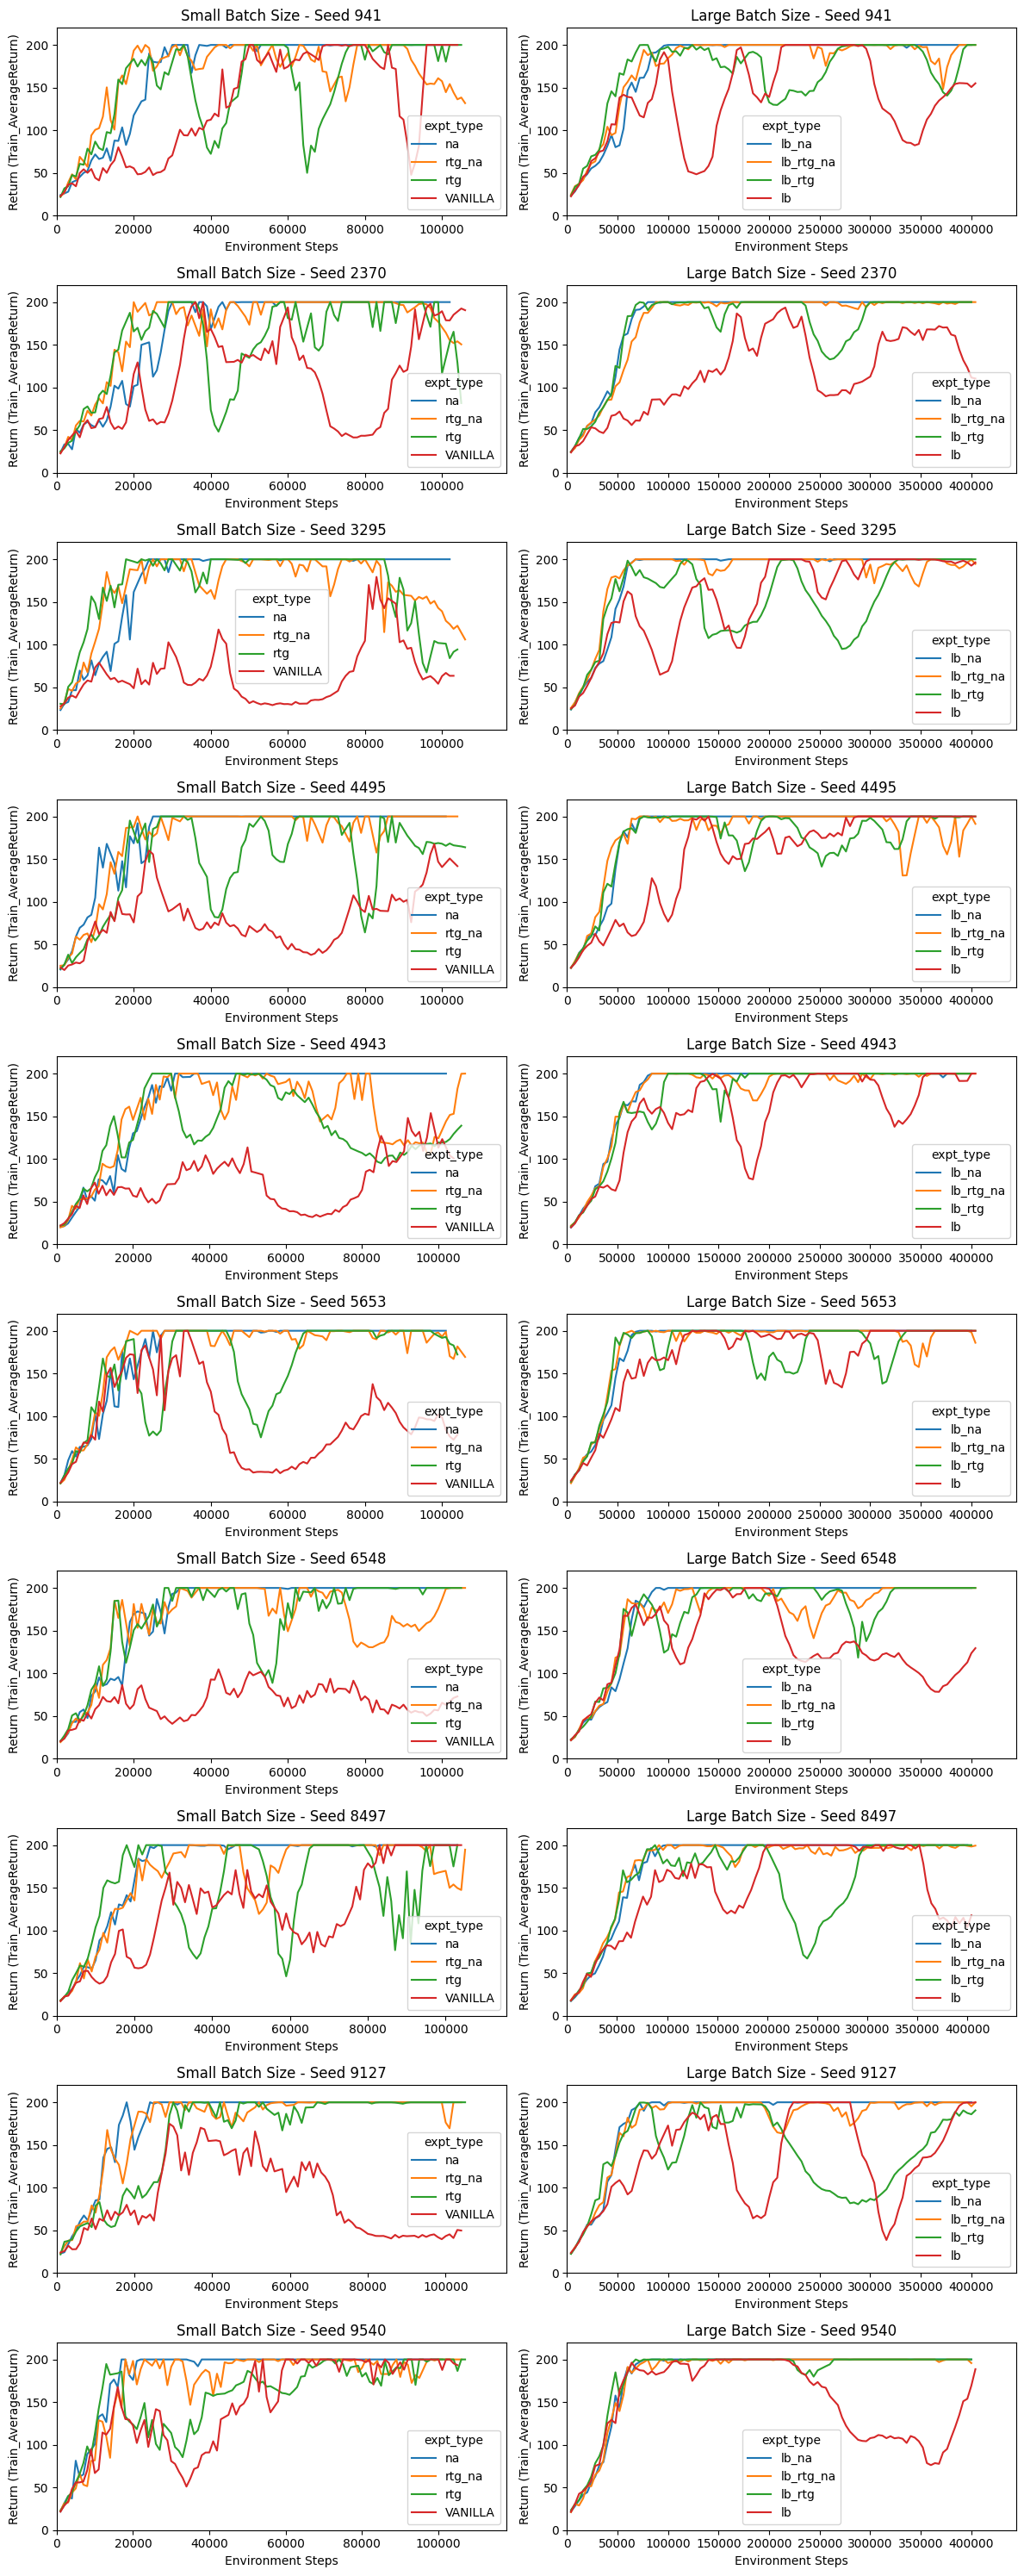

In [63]:
# Now plot for each seed.
# Tile all the plots together.
def plot_seeds(return_key, env_steps_key):
    fig, axs = plt.subplots(len(seeds), 2, figsize=(12, 3 * len(seeds)))
    for i, seed in enumerate(seeds):
        df_small = df_seeds_small[seed]

        return_df = df_small[df_small['tag'] == return_key][['step', 'value', 'dir_name']]
        env_steps_df = df_small[df_small['tag'] == env_steps_key][['step', 'value', 'dir_name']]
        joined_df = pd.merge(return_df, env_steps_df, on=['step', 'dir_name'], suffixes=('_return', '_env_steps'))
        joined_df['expt_type'] = joined_df['dir_name'].apply(
            # lambda name: "_".join(name.split("_")[3:-2]).replace("AN", "NA").upper() if len(name.split("_")) > 5 else "VANILLA"
            lambda name: "_".join(name.split("_")[3:-2]) if len(name.split("_")) > 5 else "VANILLA"
        )
        # Suppress env steps to the nearest 1000 for plotting convenience.
        joined_df['value_env_steps'] = (joined_df['value_env_steps'] // 1000) * 1000
        joined_df['value_env_steps'] = joined_df['value_env_steps'].astype(int)

        sns.lineplot(
            data=joined_df,
            x='value_env_steps',
            y='value_return',
            hue='expt_type',
            palette='tab10',
            legend='full',
            ax=axs[i, 0]
        )
        axs[i, 0].set_title(f'Small Batch Size - Seed {seed}')
        axs[i, 0].set_xlabel('Environment Steps')
        axs[i, 0].set_ylabel('Return (Train_AverageReturn)')
        axs[i, 0].set_xlim(0, max(joined_df['value_env_steps']) * 1.1)
        axs[i, 0].set_ylim(0, 200 * 1.1)
        print(axs[i, 0].get_xlim(), axs[i, 0].get_ylim())

        df_large = df_seeds_large[seed]
        return_df = df_large[df_large['tag'] == return_key][['step', 'value', 'dir_name']]
        env_steps_df = df_large[df_large['tag'] == env_steps_key][['step', 'value', 'dir_name']]
        joined_df = pd.merge(return_df, env_steps_df, on=['step', 'dir_name'], suffixes=('_return', '_env_steps'))
        joined_df['expt_type'] = joined_df['dir_name'].apply(
            # lambda name: "_".join(name.split("_")[3:-2]).replace("AN", "NA").upper() if len(name.split("_")) > 5 else "VANILLA"
            lambda name: "_".join(name.split("_")[3:-2]) if len(name.split("_")) > 5 else "VANILLA"
        )
        # Suppress env steps to the nearest 4000 for plotting convenience.
        joined_df['value_env_steps'] = (joined_df['value_env_steps'] // 4000) * 4000
        joined_df['value_env_steps'] = joined_df['value_env_steps'].astype(int)
        
        sns.lineplot(
            data=joined_df,
            x='value_env_steps',
            y='value_return',
            hue='expt_type',
            palette='tab10',
            legend='full',
            ax=axs[i, 1]
        )
        axs[i, 1].set_title(f'Large Batch Size - Seed {seed}')
        axs[i, 1].set_xlabel('Environment Steps')
        axs[i, 1].set_ylabel('Return (Train_AverageReturn)')
        axs[i, 1].set_xlim(0, max(joined_df['value_env_steps']) * 1.1)
        axs[i, 1].set_ylim(0, 200 * 1.1)
        print(axs[i, 0].get_xlim(), axs[i, 0].get_ylim())
    # fig.legend(title='Experiment', loc='lower right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    # fig.suptitle(f'Return ({return_key}) vs Environment Steps for Seeds', fontsize=16)
    return fig

fig = plot_seeds(
    return_key='Train_AverageReturn',
    env_steps_key='Train_EnvstepsSoFar',
)
plt.tight_layout()
fig.show()
fig.savefig(Path('data', 'plots', 'return-vs-env-steps-seeds.png'))